# Релиз 1.0

### Импортируем библиотеки

In [667]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
plt.style.use('ggplot')

### Выгружаем csv файл в ДатаСет

In [668]:
df = pd.read_csv('/home/cdxxi/Загрузки/_data.csv')
pd.options.display.max_columns = None

### Выкинем сразу ненужные столбцы?

In [669]:
df = df.drop(columns=['Серия дома', 'Ссылка на объявление', 'Телефоны', 'Описание', 'Unnamed: 0', 'Название ЖК', 'Можно с детьми/животными', 'Тип'])

In [670]:
#Исправим цену
df['Цена'] = df['Цена'].str.split(' ')
df1 = pd.DataFrame(df['Цена'].tolist(), index=df.index)
df1[0] = df1[0].str.replace('руб./', '')
df['Цена']=df1[0]
df['Цена'] = df['Цена'].astype(float)

In [671]:
#Удалим дубликаты по ID
df.drop_duplicates(subset=['ID  объявления'], keep='first', inplace=True)

In [672]:
#Удалим другие города кроме МСК
df_msk = df[df['Адрес'].str.contains('Москва')].reset_index()

In [673]:
#Сколько NaN и где? (проверяю по мере заполнения)
df_msk.isna().sum()

index                     0
ID  объявления            0
Количество комнат       535
Метро                   346
Адрес                     0
Площадь, м2               0
Дом                       0
Парковка              11174
Цена                      0
Ремонт                 2463
Площадь комнат, м2     7228
Балкон                 6630
Окна                   5150
Санузел                2041
Дополнительно           272
Высота потолков, м     9202
Лифт                   4192
Мусоропровод           8007
dtype: int64

### Заполним NaN

In [674]:
#Настроим адреса - чтобы была только Москва + (населенный пункт если применимо) + улица + дом
df_msk['Адрес'] = [x.split('ш. ')[0] for x in df_msk['Адрес']]

In [675]:
lst = df_msk['Адрес'].tolist()
lst1 = [str(index) + ', ' + features for index, features in enumerate(lst)]
lst2 = [x.split(',') for x in lst1]
lst3 = [' '.join(' '.join(x).strip().split()[2:-1]) for x in lst2]

#Обновляем колонку в df
df_msk['Адрес'] = lst3

In [676]:
#Парковка
df_msk['Парковка'] = df_msk['Парковка'].fillna('Бесплатная во дворе')

In [677]:
#Количество комнат
def room_count(s):
    if len(s) > 1:
        return int(s.split(',')[0])
    else:
        return int(s)
df_msk['Количество комнат'] = df_msk['Количество комнат'].fillna('0')
df_msk['Количество комнат'] = df_msk['Количество комнат'].apply(room_count)

In [678]:
#Метро
df_msk['Метро'] = df_msk['Метро'].fillna('м. Отсутствует рядом (0 мин пешком)')
df_msk['Метро'] = [x.split(' (')[0] for x in df_msk['Метро']]
df_msk['Метро'] = [x.split('. ')[1] for x in df_msk['Метро']]

In [679]:
#Ремонт
df_msk['Ремонт'] = df_msk['Ремонт'].fillna('Без ремонта')

In [680]:
#Площадь - разобьем на жилую/нежилую
df_msk['Площадь общая, м2'] = [float(x.split('/')[0]) for x in df_msk['Площадь, м2']]

In [681]:
#Выкинем теперь площадь комнат
df_msk = df_msk.drop(columns=['Площадь комнат, м2', 'Площадь, м2'])

In [682]:
#Балконы - заполним NaN, разделим по двум столбцам
df_msk['Балкон'] = df_msk['Балкон'].fillna('Балкон (0)')
df_msk['Лоджия'] = [x.split(' ')[-1] if x.split(' ')[-2] == 'Лоджия' else 0 for x in df_msk['Балкон']]
df_msk['Балкон'] = [x.split(' ')[1] if x.split(' ')[0] == 'Балкон' else 0 for x in df_msk['Балкон']]

In [683]:
#Убрать скобки у балконов
# d_balcony = {'0':0, '1':1, '2':2, '3':3, '4':4}
df_msk['Балкон'] = [int(x[1]) if type(x) == str else 0 for x in df_msk['Балкон']]
df_msk['Лоджия'] = [int(x[1]) if type(x) == str else 0 for x in df_msk['Лоджия']]

In [684]:
#Окна - заполним NaN 
df_msk['Окна'] = df_msk['Окна'].fillna('На улицу или двор')

In [685]:
#Санузлы - делаем как с балконами
df_msk['Санузел'] = df_msk['Санузел'].fillna('Совмещенный (1)')
df_msk['Санузел разд.'] = [x.split(' ')[-1] if x.split(' ')[-2] == 'Раздельный' else 0 for x in df_msk['Санузел']]
df_msk['Санузел совм.'] = [x.split(' ')[1] if x.split(' ')[0] == 'Совмещенный' else 0 for x in df_msk['Санузел']]

In [686]:
#Вторая часть про санузлы - вытащили значения, сделали из них int принудительно :)
df_msk['Санузел разд.'] = [int(x[1]) if type(x) == str else 0 for x in df_msk['Санузел разд.']]
df_msk['Санузел совм.'] = [int(x[1]) if type(x) == str else 0 for x in df_msk['Санузел совм.']]
df_msk = df_msk.drop(columns=['Санузел'])

In [687]:
#Разберемся с колонкой "Дополнительно". Логика такая -> не прописано - значит квартира пустая
df_msk['Дополнительно'] = df_msk['Дополнительно'].fillna('Отсутствует')

In [688]:
#Сделаем в колонке два вывода - "Присутствуют удобства" если там все, кроме "Отсутствует", и "Отсутствуют удобства" в ином случае
df_msk['Дополнительно'] = ['Отсутствуют удобства' if x == 'Отсутствует' else 'Присутствуют удобства' for x in df_msk['Дополнительно']]

In [689]:
#Потолки... настало ваше время... Пропуски заполним средним значением, округлим после точки до двух символов
df_msk['Высота потолков, м'] = df_msk['Высота потолков, м'].fillna(round(df_msk['Высота потолков, м'].mean(), 2))

In [690]:
#Из колонки Дом получить колонку Дом и Этаж
# df_msk['Этаж'] = [x.split(',')[0][0] for x in df_msk['Дом']]
df_msk['Тип дома'] = [x.split(', ')[-1] if len(x.split(', ')[-1]) > 6 else 'Неизвестно' for x in df_msk['Дом']]
df_msk['Этажи'] = [int(x.split('/')[1].split(',')[0]) for x in df_msk['Дом']]
df_msk['Этаж квартиры'] = [int(row.split('/')[0]) for row in df_msk['Дом']]
df_msk = df_msk.drop(['Дом'], axis=1)

In [691]:
#Лифты. Заполним NaN - пусть будет Пасс (0), Груз (0), если меньше 5 этажей
df_msk['Лифт'] = [x if x == x else ['Пасс (1), Груз (1)' if df_msk['Этажи'].iloc[i]>5 else 'Пасс (0), Груз (0)'][0]for i, x in enumerate(df_msk['Лифт'])]

In [692]:
#Разделим лифты на две колонки - груз и пасс, удалим старую колонку
df_msk['Лифт груз.'] = [x.split(' ')[-1] if x.split(' ')[-2] == 'Груз' else 0 for x in df_msk['Лифт']]
df_msk['Лифт пасс.'] = [x.split(' ')[1] if x.split(' ')[0] == 'Пасс' else 0 for x in df_msk['Лифт']]

In [693]:
#Заменим у лифтов значения на type=int
df_msk['Лифт груз.'] = [int(x[1]) if type(x) == str else 0 for x in df_msk['Лифт груз.']]
df_msk['Лифт пасс.'] = [int(x[1]) if type(x) == str else 0 for x in df_msk['Лифт пасс.']]
df_msk = df_msk.drop(columns=['Лифт'])

In [694]:
#Обработаем мусоропровод от NaN
df_msk['Мусоропровод'] = df_msk['Мусоропровод'].fillna('Нет')

In [695]:
#Уберем цену в конец графика
last_column = df_msk.pop('Цена')
df_msk.insert(df_msk.shape[1], 'Цена', last_column)

### Рисуем графики зависимости цены от оставшихся признаков

In [696]:
#Функция, чтобы построить все графики зависимости оставшихся признаков от цены
def plot_price(column, df, price_col='Цена'):
    if df[column].dtype == 'object':
        fig, ax = plt.subplots()
        sns.barplot(data=df, x=column, y=price_col, ax=ax)
        plt.title(column)
        plt.yticks(rotation=45)
        plt.xticks(rotation=45)
    else:
        fig, ax = plt.subplots()
        sns.lineplot(data=df, x=column, y=price_col, ax=ax)
        plt.title(column)
        plt.yticks(rotation=45)
        plt.xticks(rotation=45)


In [697]:
#Выносим признаки, проходимся по ним, выдаем графики
# cat = df_msk.columns.tolist()[2:-1]
# for col in cat:
#     plot_price(col, df_msk)

### Нарисуем графики вручную, т.к. при автоматизации некоторые из них ломаются

In [698]:
# df_msk.columns.tolist()[2:-1]

<Axes: xlabel='Цена', ylabel='Количество комнат'>

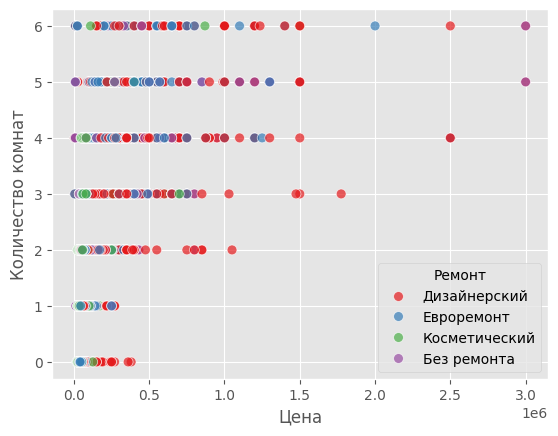

In [699]:
#Влияет ли количество комнат на цену? (сразу добавим hue=ремонт)
fig,ax = plt.subplots()
sns.scatterplot(data=df_msk, x='Цена', y='Количество комнат', hue='Ремонт', palette='Set1', alpha=0.7, s=50, ax=ax)

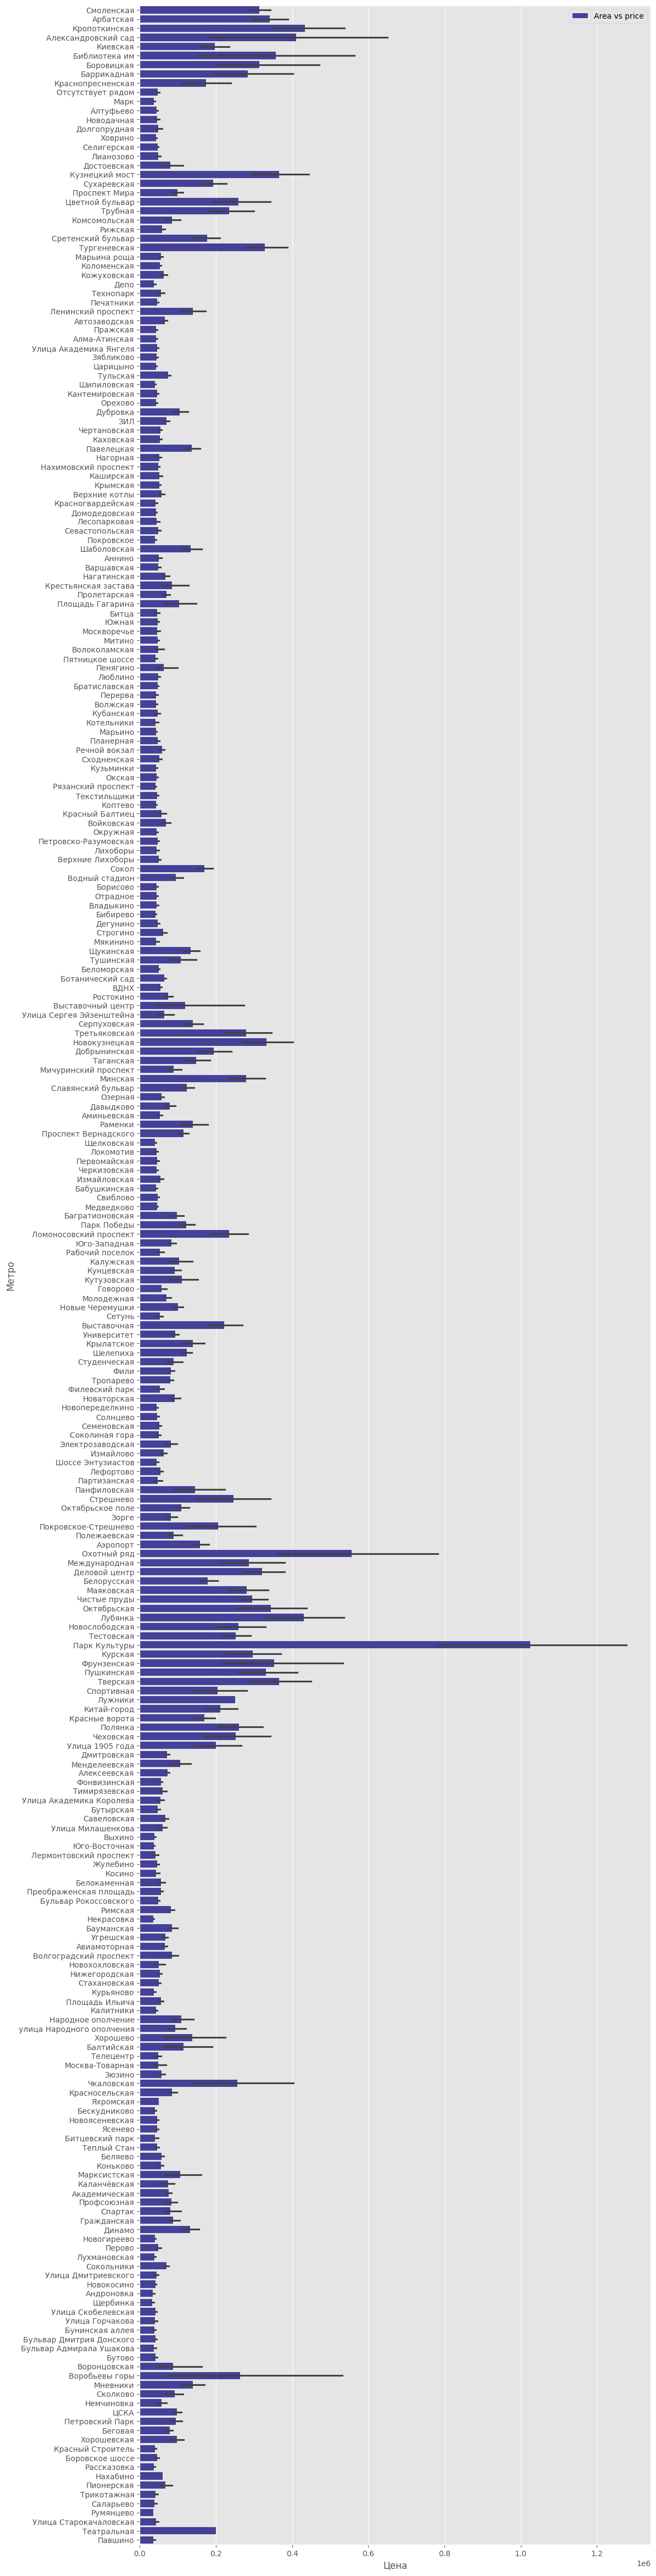

In [700]:
#Влияние метро на цену (явно имеется)
figure = plt.subplots(figsize=(12,60))
sns.barplot(data=df_msk, x='Цена', y='Метро', orient='h', label='Area vs price', color='#3632a8')
plt.legend()

<Axes: xlabel='Цена', ylabel='Адрес'>

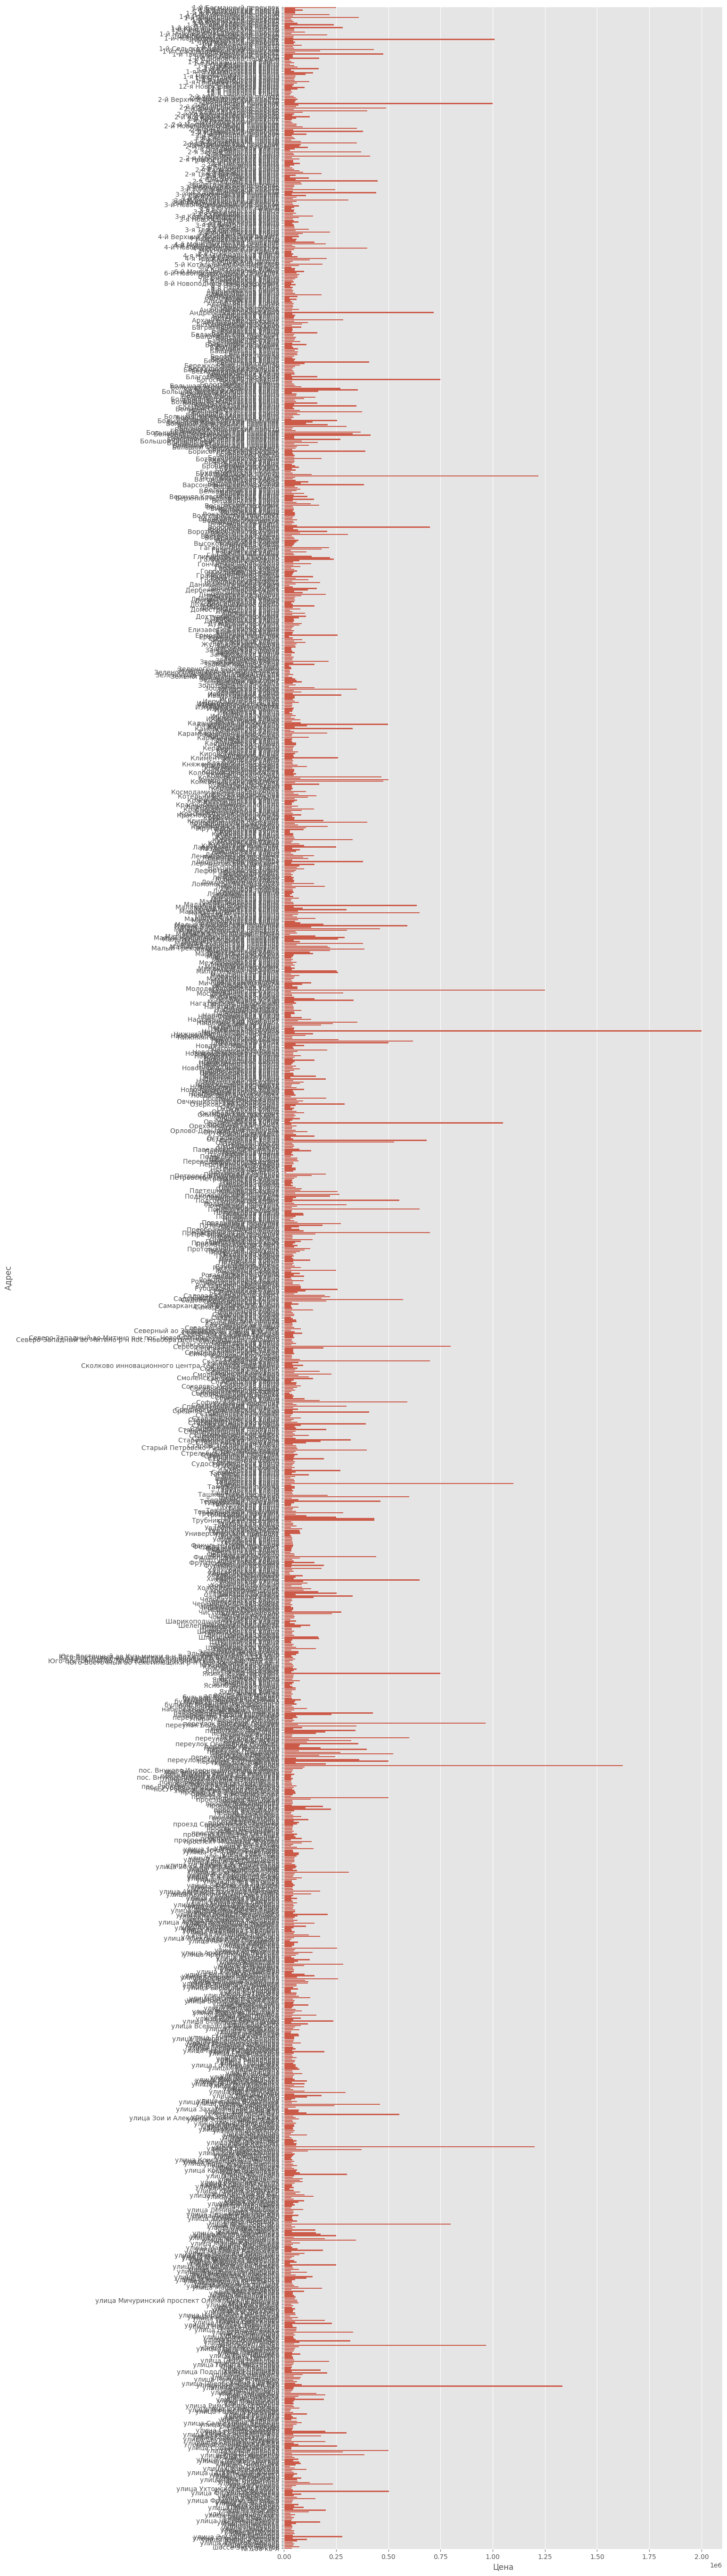

In [701]:
#Влияние улицы на цену
df_add = df_msk.groupby('Адрес')['Цена'].mean().reset_index()
df_add

fig, ax = plt.subplots(figsize=(12, 70))
sns.barplot(data=df_add, x='Цена', y='Адрес', orient='h', ax=ax)

<Axes: xlabel='Цена', ylabel='Тип дома'>

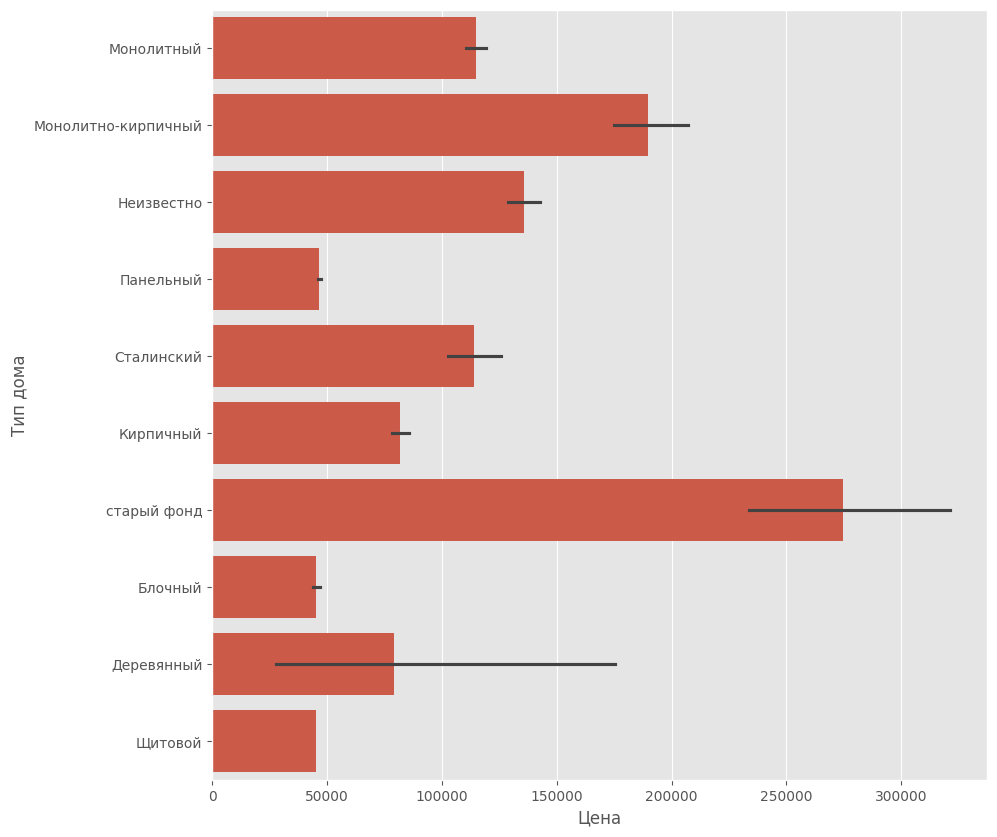

In [702]:
#Влияние дома на цену
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=df_msk, x='Цена', y='Тип дома', ax=ax)

In [703]:
df_msk.dtypes #чтобы проще было графики строить, ориентируясь на type

index                   int64
ID  объявления          int64
Количество комнат       int64
Метро                  object
Адрес                  object
Парковка               object
Ремонт                 object
Балкон                  int64
Окна                   object
Дополнительно          object
Высота потолков, м    float64
Мусоропровод           object
Площадь общая, м2     float64
Лоджия                  int64
Санузел разд.           int64
Санузел совм.           int64
Тип дома               object
Этажи                   int64
Этаж квартиры           int64
Лифт груз.              int64
Лифт пасс.              int64
Цена                  float64
dtype: object

<Axes: xlabel='Цена', ylabel='Парковка'>

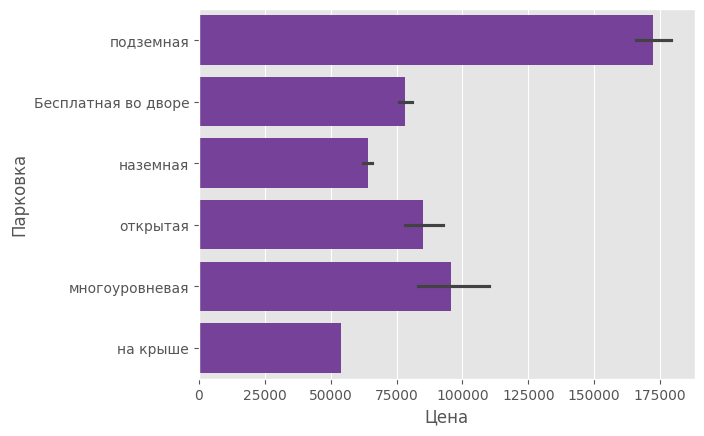

In [704]:
#Влияние парковки на цену
df_msk['Парковка'].unique()
figure = plt.subplots()
sns.barplot(data=df_msk, x='Цена', y='Парковка', color='#7932a8')

<Axes: xlabel='Цена', ylabel='Балкон'>

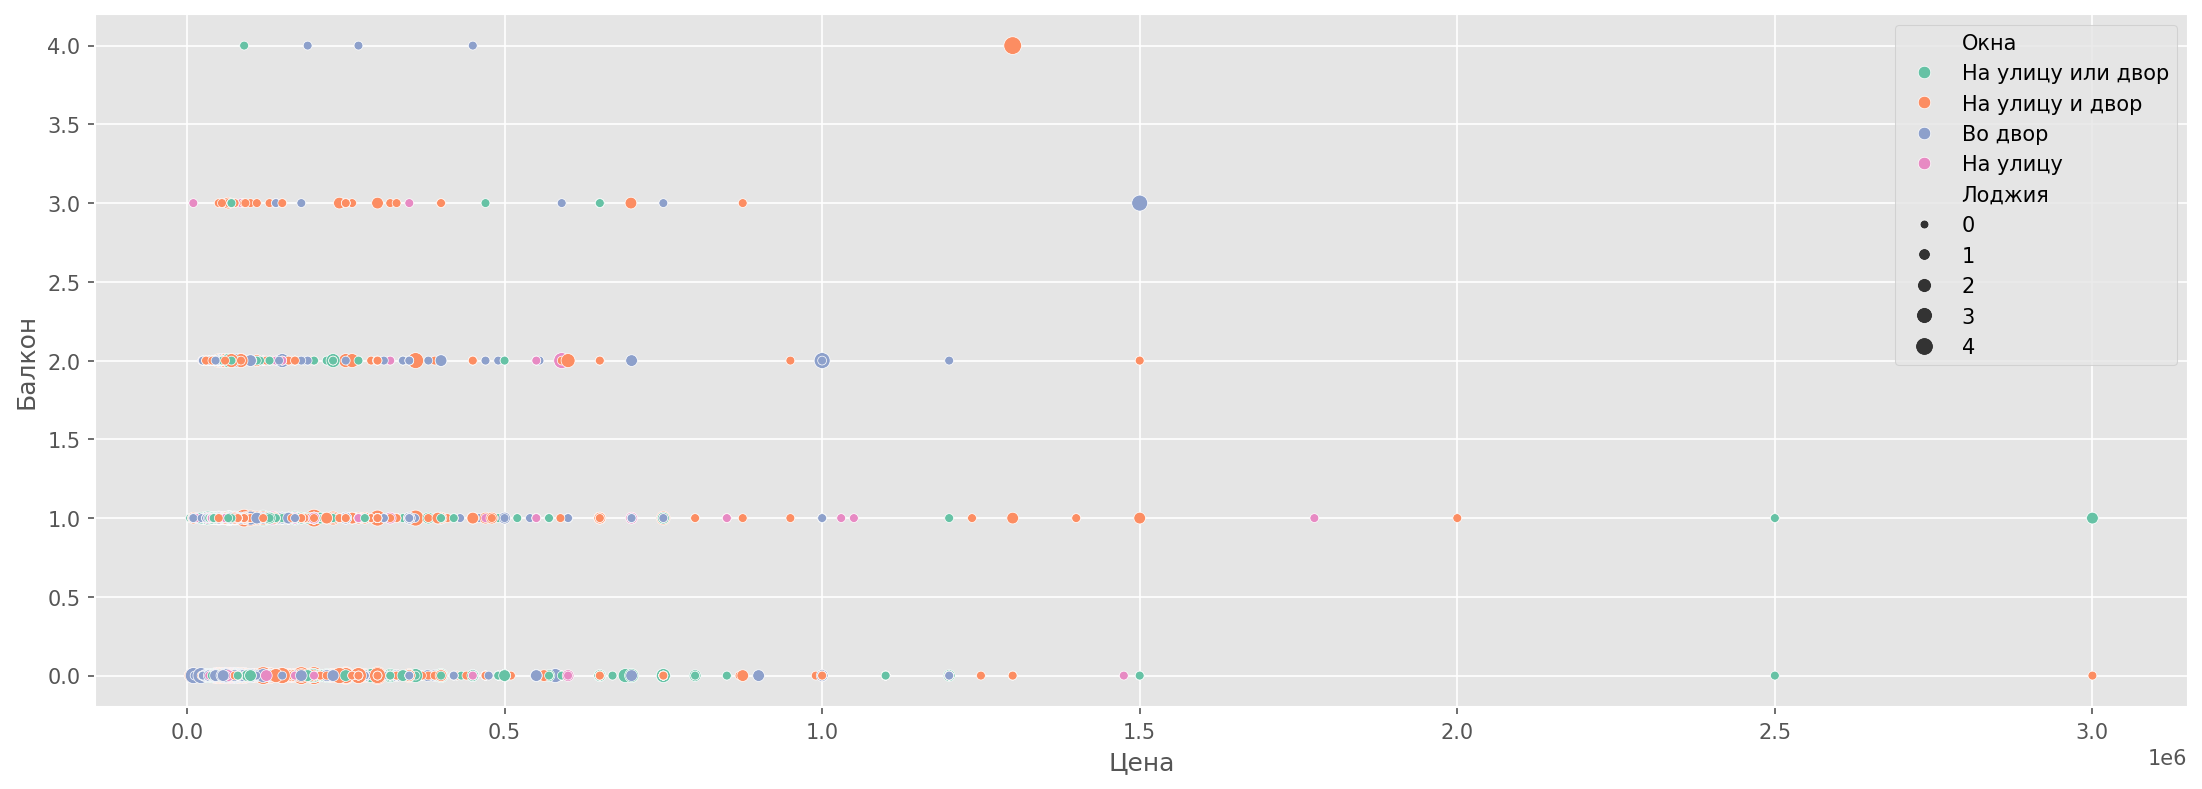

In [705]:
#Влияние балконов на цену
figure = plt.subplots(figsize=(18,6), dpi=150)
sns.scatterplot(data=df_msk, x='Цена', y='Балкон', hue='Окна', size='Лоджия', palette='Set2')

<Axes: xlabel='Дополнительно', ylabel='Цена'>

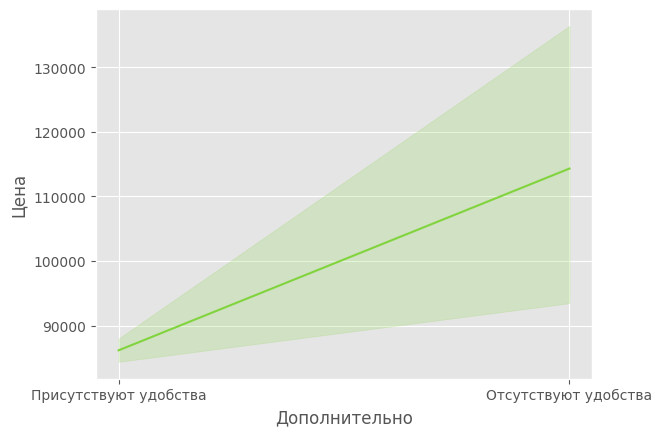

In [706]:
#Влияние дополнительные удобств на цену 
figure = plt.subplots()
sns.lineplot(data=df_msk, x='Дополнительно', y='Цена', color='#81d43d')

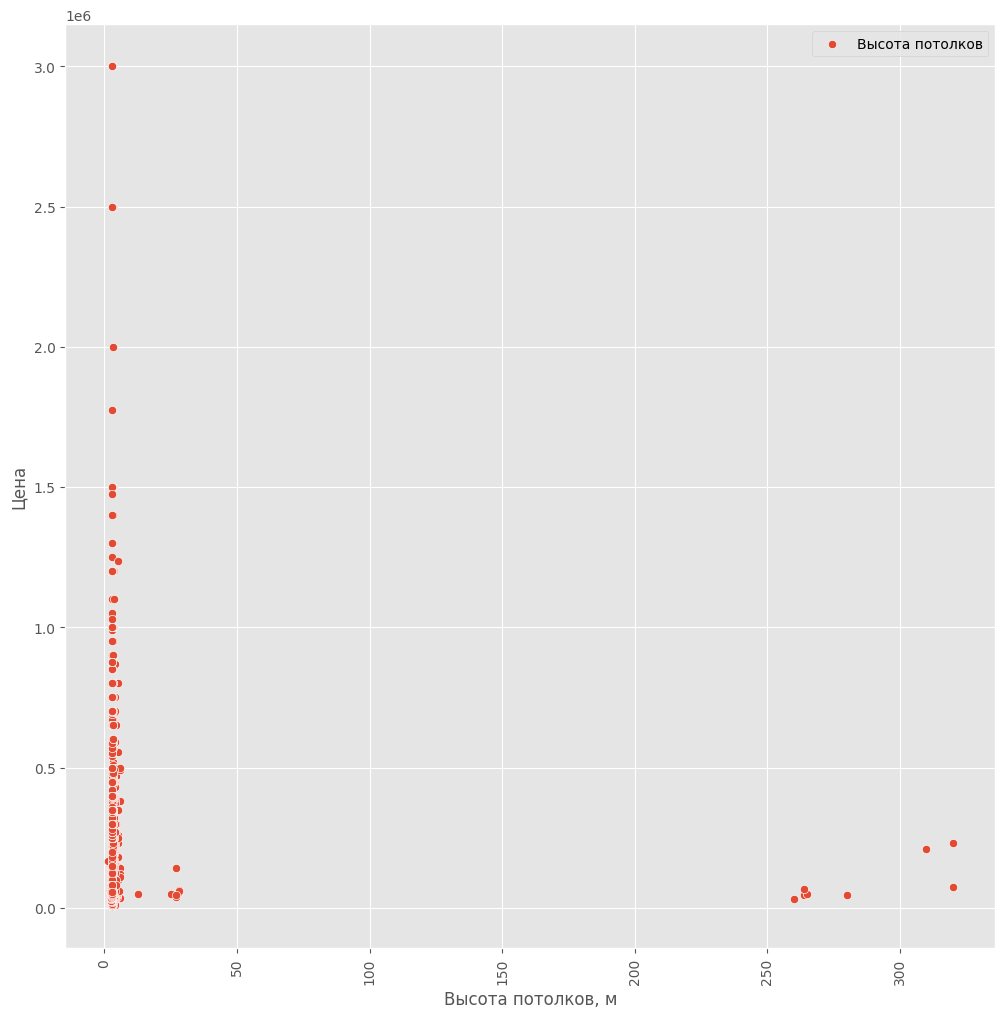

In [707]:
#Влияние высоты потолков на цену 
figure = plt.subplots(figsize=(12,12))
sns.scatterplot(data=df_msk, x='Высота потолков, м', y='Цена', label='Высота потолков')
plt.xticks(rotation=90)
plt.legend()

<Axes: xlabel='Цена', ylabel='Мусоропровод'>

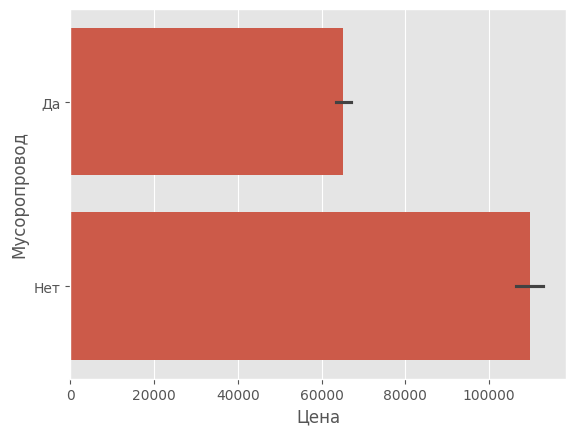

In [708]:
#Влияние наличия мусоропровода на цену   (более старые квартиры имеют мусоропровод - отсюда цена ниже)
figure = plt.subplots()
sns.barplot(data=df_msk, x='Цена', y='Мусоропровод', orient='h')

<Axes: xlabel='Площадь общая, м2', ylabel='Цена'>

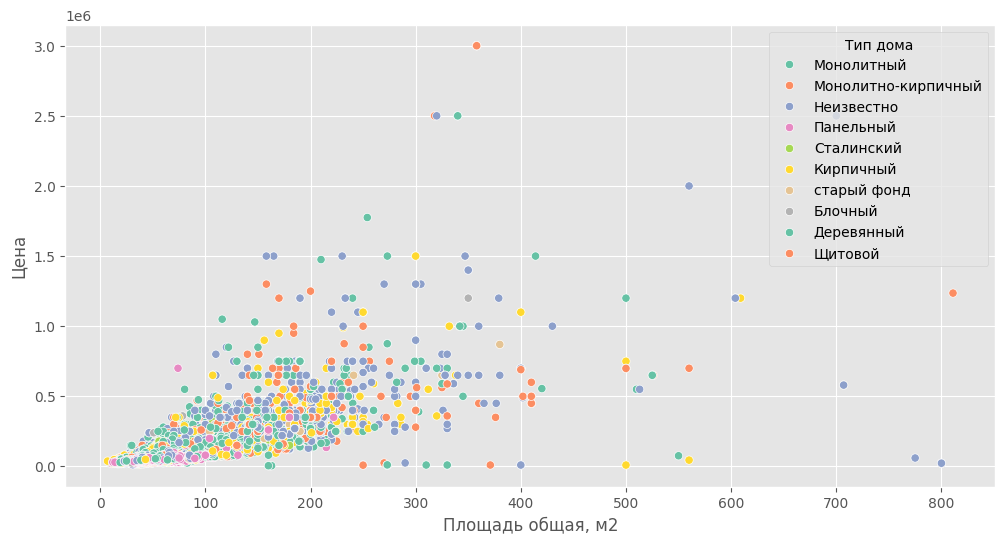

In [709]:
#Влияние площади общей, площади жилой и площади кухни
figure = plt.subplots(figsize=(12,6))
sns.scatterplot(data=df_msk, x='Площадь общая, м2', y='Цена', hue='Тип дома', palette='Set2')

<Axes: xlabel='Санузел совм.', ylabel='Цена'>

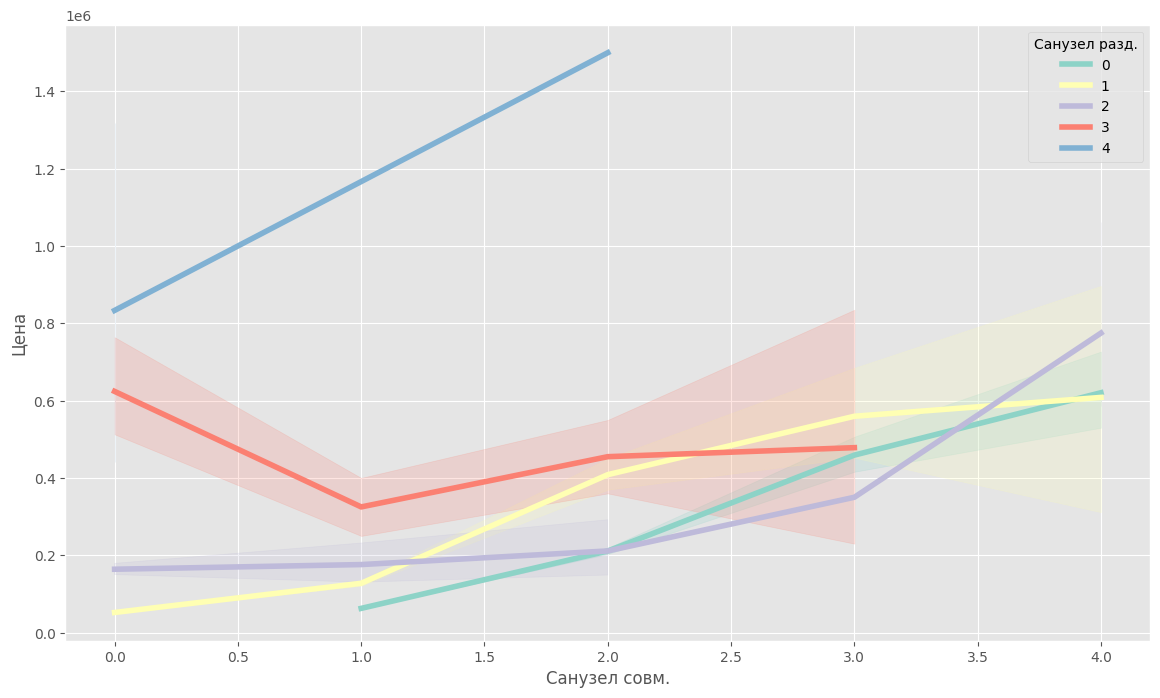

In [ ]:
#Зависимость цены от санузлов
figure = plt.subplots(figsize=(14,8))
sns.lineplot(data=df_msk, x='Санузел совм.', y='Цена', hue='Санузел разд.', palette='Set3', linewidth=4)

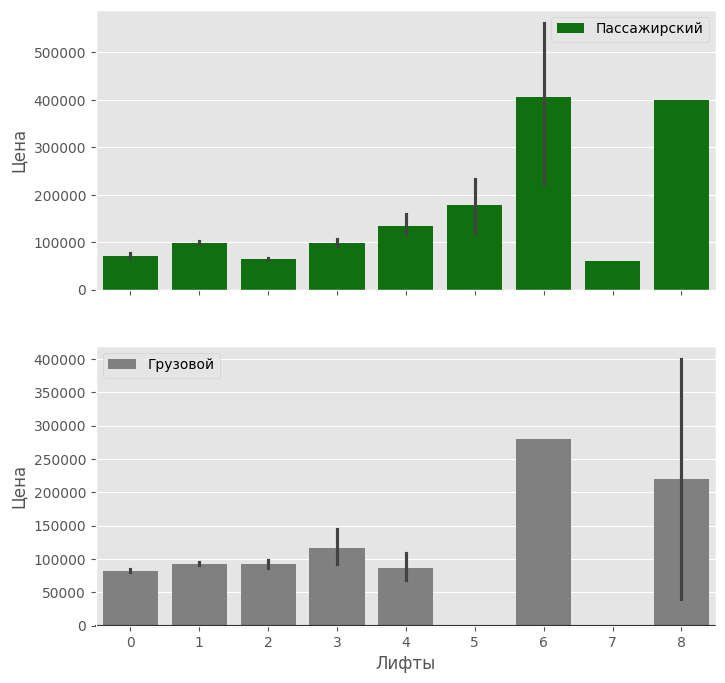

In [711]:
#Влияние лифтов на цену
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
sns.barplot(x='Лифт пасс.',y='Цена', data=df_msk, label='Пассажирский', ax=ax1, color='green')
sns.barplot(x='Лифт груз.',y='Цена', data=df_msk, label='Грузовой', ax=ax2, color='grey')
ax2.set_xlabel('Лифты')
ax2.axhline(0, color="k", clip_on=False)

Text(0.5, 1.0, 'Влияние числовых значений друг на друга')

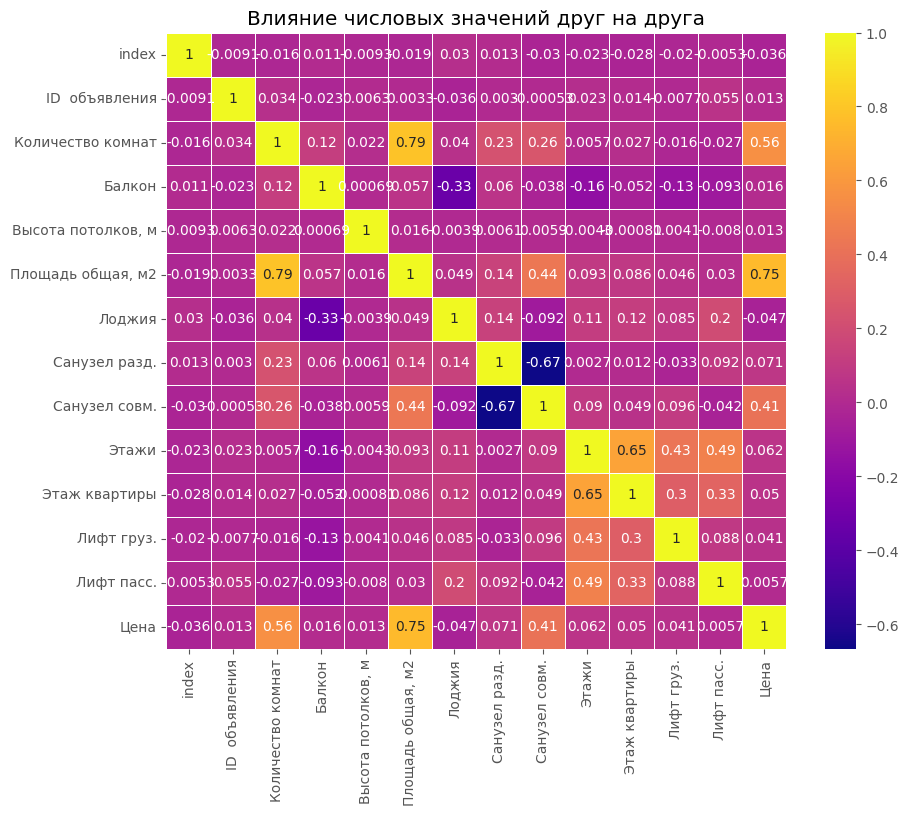

In [712]:
#Влияние числовых признаков друг на друга через heatmap
num_cols = df_msk.select_dtypes(include=['number']).columns    #только числовые из всех
figure = plt.subplots(figsize=(10,8))
sns.heatmap(df_msk[num_cols].corr(), annot=True, cmap='plasma', linewidth=0.5)
plt.title('Влияние числовых значений друг на друга')